# Project 1
**Authors in Group Zero:**<br>
**Dustin Hepker**<br>
**Grant Rustan**<br>
**Owen Michael**<br>
**Preston Bouschlicher**<br>

## Introduction
The primary objective of this project is to build a regression model that accurately predicts faculty salaries at Ohio colleges based on features such as job description, department, and school. The model's performance will be evaluated using metrics such as Root Mean Squared Error (RMSE) and R² Score.

The dataset used for this project is sourced from [Kaggle](https://www.kaggle.com/datasets/asaniczka/university-employee-salaries-2011-present/data?select=higher_ed_employee_salaries.csv). It contains six columns:  `Name`, `School`, `Job Description`, `Department`, `Earnings`, and `Year`, with over 260,000 unique entries of faculty members from Ohio colleges spanning the years 2011 to 2022.


In [23]:
# Cell 1
# Create functions necessary for processing as well as import needed libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import matplotlib.patches as mpatches

# Helper function to create a dataframe with the features and the set sample size
def get_features_df(csv_name, chosen_features, sample_decimal_size):
    df = pd.read_csv(csv_name).sample(frac=sample_decimal_size, random_state=2)
    df = df[chosen_features]
    df.dropna(inplace=True)
    return df

def get_best_model(models, X_train, y_train):
    results = {}
    for name, model in models.items():
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
        rmse_scores = np.sqrt(-scores)
        results[name] = rmse_scores.mean()
        print(f"{name}: RMSE = {rmse_scores.mean():.2f}")

    return min(results, key=results.get)



## Initializing containers

In this section we load the dataset "higher_ed_employee_salaries.csv", select columns, and only focus on meaningful data.
1. We remove entries with earnings under $30,000 to be able to focus on only full-time employees.
2. Filter data for years 2020 and later to focus on recent trends.

These specifications ensure outliers are less harmful to the model.

In [24]:
# Cell 2
# Create the containers we will be evaluating
features = ["School","Job Description", "Earnings", "Department", "Year"]
# "Name","School","Job Description","Department","Earnings","Year"
df = get_features_df("higher_ed_employee_salaries.csv", features, 0.02)

del features

target_column = "Earnings"
alpha = 0.03
beta = alpha
# Effectively eliminate full-time work
df = df[df["Earnings"] >= 30000]
# Elimate older data
df = df[df["Year"] >= 2015]

q_low = df[target_column].quantile(0.00 + beta)
q_high = df[target_column].quantile(1.00 - alpha)
df = df[(df[target_column] >= q_low) & (df[target_column] <= q_high)]

df_without_target = df.drop(columns=[target_column])

unique_roles = df_without_target.dropna().drop_duplicates().reset_index(drop=True)

y = df[target_column]

del alpha
del beta
del q_high
del q_low
del df
del target_column

X = pd.get_dummies(df_without_target, 
                   columns=['School','Job Description', 'Department'])

column_names = X.columns

del df_without_target

# Result of our effort
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

del X


## Data Exploration and Preprocessing

We began by exploring the dataset to understand its structure and characteristics. We analyzed the distribution of salaries across different job titles and departments, identified potential outliers, and handled missing values.


In [ ]:
# Cell 3
# Split data and designate models
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

X_unique = pd.get_dummies(unique_roles)

X_unique = X_unique.reindex(columns=column_names, fill_value=0)

del column_names

X_unique_scaled = scaler.transform(X_unique)

del scaler
del X_scaled

models = {
    "Ridge": Ridge(),
    "KNN9": KNeighborsRegressor(n_neighbors=9),
    "KNN13": KNeighborsRegressor(n_neighbors=13),
    "SGD": SGDRegressor(
        max_iter=2000,
        tol=1e-3,
        penalty="l2",
        alpha=0.0001,
        learning_rate="invscaling",
        eta0=0.001,            
        random_state=42
    ),
    "SGD_Lasso": SGDRegressor(
        penalty='l1',
        alpha=0.001,                 
        max_iter=5000,                
        tol=1e-4,                     
        learning_rate='invscaling',  
        eta0=0.0001,                 
        early_stopping=True,        
        validation_fraction=0.1,     
        n_iter_no_change=5,           
        random_state=42
    )
}


## Model Selection and Evaluation

We experimented with different regression models, including Ridge, KNeighborsRegressor, and SGDRegressor. We evaluated the models using cross-validation and selected the best-performing model based on RMSE. The chosen model was then trained on the training data and evaluated on the test data.

In [26]:
# Cell 4
# Set model to the best found
best_model = get_best_model(models, X_train, y_train)
model = models[best_model]

del best_model
del models

print(f"\nBest model: {model}")


Ridge: RMSE = 29590.96
KNN9: RMSE = 33255.49
KNN13: RMSE = 32827.57
SGD: RMSE = 63790.87
SGD_Lasso: RMSE = 63915.35

Best model: Ridge()


## Results and Discussion

The selected model achieved a satisfactory performance on the test data, demonstrating its ability to predict salaries with reasonable accuracy. We further analyzed the model's predictions to gain insights into the factors influencing salary variations in higher education.

In [27]:
# Cell 5
# Train our found model
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_r2 = r2_score(y_test, y_pred)

print(f"\nTest Set Evaluation for Best Model {model}:")
print(f"Test RMSE: ${test_rmse:.2f}")
print(f"Test R² Score: {test_r2:.4f}")

del test_rmse
del test_r2

role_predictions = model.predict(X_unique_scaled)

roles_df = unique_roles.copy()
roles_df["Predicted Salary"] = np.round(role_predictions).astype(int)

mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
smape = 100 * np.mean(2 * np.abs(y_pred - y_test) / (np.abs(y_pred) + np.abs(y_test)))

print(f"SMAPE: {smape:.2f}%")
print(f"MAE: ${mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print("\nPredicted Salaries for Unique Job Description + Department Pairs:\n")
display(roles_df.sort_values("Predicted Salary", ascending=False).head(20)) 




Test Set Evaluation for Best Model Ridge():
Test RMSE: $27280.18
Test R² Score: 0.3556
SMAPE: 27.81%
MAE: $19523.89
MAPE: 29.85%

Predicted Salaries for Unique Job Description + Department Pairs:



,School,Job Description,Department,Year,Predicted Salary
1710,The Ohio State University,Managing Attorney,Shared Services,2019,226641
287,Youngstown State University,Provost & VP Acad. Affairs,Provost VP - Academic Affairs,2020,225194
3710,The Ohio State University,Supervisor-Perfusion Services,Ross Heart Hospital,2017,225131
1987,University Of Cincinnati,Sr Vice Provost,Provost Business & Financial Affairs,2015,223494
659,The Ohio State University,Radiation Physicist 2,James | SSCBC Radiation Oncology,2022,219016
1803,Miami University,VP for Student Affairs,Student Life,2018,218259
772,The Ohio State University,Administrator,Ross Heart Hospital,2020,217809
6068,The Ohio State University,"AVP, Digital Strategy & Marketing Automation",Health System,2021,215474
3337,The Ohio State University,Assistant Vice President,Advancement | Development General,2022,213967
1246,Miami University,Endres Associate Professor,Management,2019,213853


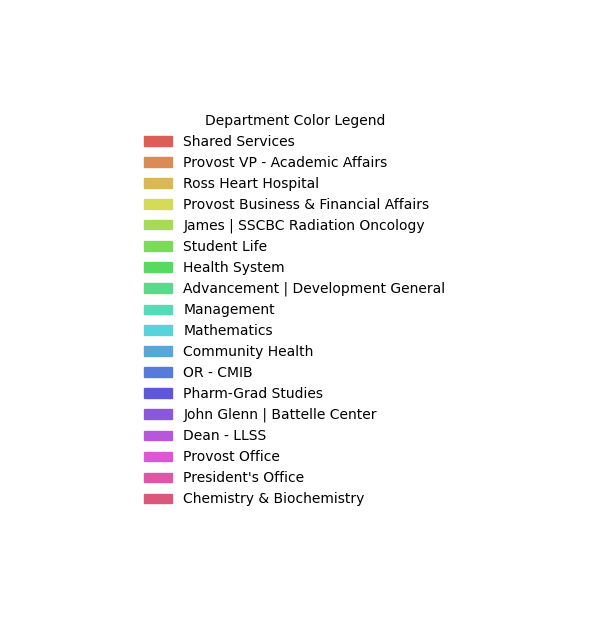

In [28]:
# Cell 6
# Display the legend

top_roles = roles_df.sort_values("Predicted Salary", ascending=False).head(20)

unique_departments = top_roles["Department"].unique()

palette = sns.color_palette("hls", n_colors=len(unique_departments))
dept_color_map = dict(zip(unique_departments, palette))

handles = [
    mpatches.Patch(color=dept_color_map[dept], label=dept)
    for dept in unique_departments
]

fig_legend = plt.figure(figsize=(6, len(handles) * 0.35))
plt.legend(
    handles=handles,
    loc='center',
    title="Department Color Legend",
    frameon=False
)
plt.axis('off')
plt.tight_layout()
plt.savefig("legend_only.png", dpi=300)
plt.show()


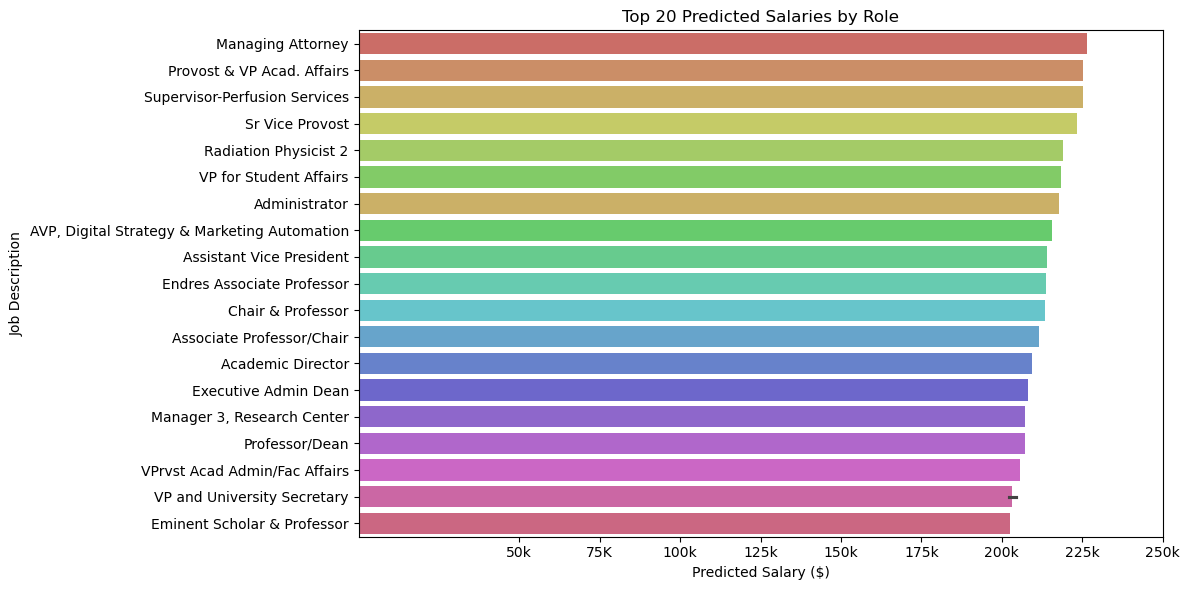

In [29]:
# Cell 7
# Highest earners
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=top_roles,
    x="Predicted Salary",
    y="Job Description",
    hue="Department",
    dodge=False,
    palette=dept_color_map
)

plt.title("Top 20 Predicted Salaries by Role")
plt.xlabel("Predicted Salary ($)")
plt.ylabel("Job Description")
plt.xticks(ticks=[50000, 75000, 100000, 125000, 150000, 175000, 200000, 225000, 250000], labels=["50k", "75K", "100k", "125k", "150k", "175k", "200k", "225k", "250k"])

ax.legend_.remove()

plt.tight_layout()
plt.savefig("bar_chart_without_legend.png", dpi=300)
plt.show()

A scatter plot for our data


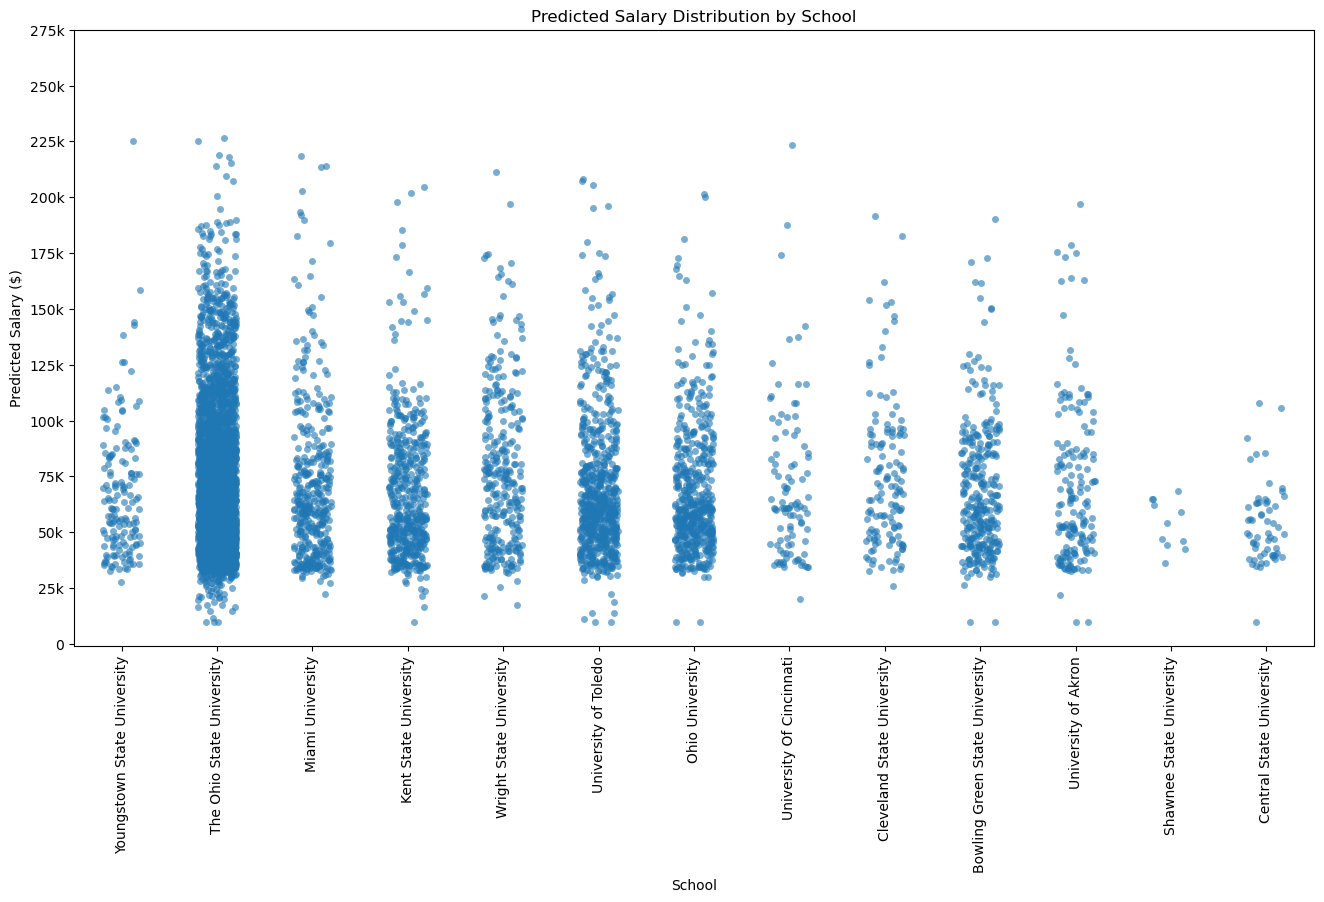

In [30]:
# Cell 8

roles_df["Predicted Salary"] = roles_df["Predicted Salary"].clip(lower=10000)
# Scatterplot
print("A scatter plot for our data")
plt.figure(figsize=(16, 8))
sns.stripplot(data=roles_df, x="School", y="Predicted Salary", jitter=0.2, alpha=0.6)
plt.title("Predicted Salary Distribution by School")
plt.yticks(
    ticks=[0, 25000, 50000, 75000, 100000, 125000, 150000, 175000, 200000, 225000, 250000,275000], 
    labels=["0","25k","50k", "75K", "100k", "125k", "150k", "175k", "200k", "225k", "250k","275k"])
plt.xticks(rotation=90)
plt.ylabel("Predicted Salary ($)")
plt.xlabel("School")
plt.show()


## Conclusion

This project successfully developed a machine learning model for predicting salaries in higher education. The insights gained from this project can be valuable for understanding salary trends and informing decision-making in higher education institutions.